In [2]:
library(hipathia)
library(circlize)
library(ComplexHeatmap)
library(ggplot2)
library(corrplot)
library(hipathia)
library(reshape2)
library(dplyr)
library(ggdendro)
library(limma)

In [3]:
# get data and annotations

In [4]:
annot_splattrib <- read.table("/mnt/lustre/scratch/CBRA/research/projects/heterogeneity_mm/data/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt", sep="\t", header=T)
pathvals_gtex <- readRDS("/mnt/lustre/scratch/CBRA/research/projects/heterogeneity_mm/results/00_mm_gtex/pathvals_gtexv8.rds")
annot_splattrib_comp <- annot_splattrib[annot_splattrib$SAMPID %in% colnames(pathvals_gtex),]
annot_splattrib_comp <- annot_splattrib_comp[annot_splattrib_comp$SMTSD != "",]

pathways <- load_pathways("hsa")
pathvals <- assay(pathvals_gtex)
path_names <- get_path_names(pathways,rownames(pathvals))
rownames(pathvals) <- path_names

annot_subph <- read.table("/mnt/lustre/scratch/CBRA/research/projects/heterogeneity_mm/data/GTEx_Analysis_v8_Annotations_SubjectPhenotypesDS.txt", sep="\t", header=T)
rownames(annot_subph) <- annot_subph$SUBJID

Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
“EOF within quoted string”
Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
“number of items read is not a multiple of the number of columns”
Loaded 146 pathways



In [5]:
annot_splattrib_sl <- annot_splattrib[,c("SAMPID","SMTS","SMTSD")]
rownames(annot_splattrib_sl) <- annot_splattrib_sl$SAMPID

comp_pat <- intersect(annot_splattrib_sl$SAMPID, colnames(pathvals))
subjib_comp_pat <- paste("GTEX-",unique(unlist(lapply(strsplit(comp_pat,"-", fixed=T), FUN=function(x) x[2]))), sep="")

annot_subph_comp <- annot_subph[subjib_comp_pat,]                                                                 
list_patient <- lapply(annot_subph_comp$SUBJID, FUN=function(x) annot_splattrib_sl$SAMPID[grep(x, annot_splattrib_sl$SAMPID)])
list_sex <- do.call(list,lapply(1:length(annot_subph_comp$SEX), function(x) rep(annot_subph_comp$SEX[x],length(unlist(list_patient[x])))))                       
list_age <- do.call(list,lapply(1:length(annot_subph_comp$AGE), function(x) rep(annot_subph_comp$AGE[x],length(unlist(list_patient[x])))))   
pat_sex_age <- data.frame(patients = unlist(list_patient),
                                   sex = unlist(list_sex),
                                   age = unlist(list_age))
rownames(pat_sex_age) <- pat_sex_age$patients

pat_sex_age_comp <- pat_sex_age[comp_pat,]
pat_sex_age_comp$sex <- rep("-", length(pat_sex_age_comp$patients))                                
pat_sex_age_comp$sex[which(pat_sex_age_comp$sex == 2)] <- "female"
pat_sex_age_comp$sex[which(pat_sex_age_comp$sex == 1)] <- "male"
pat_sex_age_comp$tissue <- annot_splattrib_sl[pat_sex_age_comp$patients,"SMTS"]                                
pat_sex_age_comp$tissue_zone <- annot_splattrib_sl[pat_sex_age_comp$patients,"SMTSD"] 
annot_comp <- pat_sex_age_comp[,c("patients","age","sex","tissue","tissue_zone")]    
annot_comp <- annot_comp[annot_comp$tissue_zone != "",]

In [6]:
annot_comp_fcells <- annot_comp[-c(which(annot_comp$tissue_zone == 'Cells - Cultured fibroblasts'), which(annot_comp$tissue_zone == 'Cells - EBV-transformed lymphocytes')),]
pathvals_fcells <- pathvals[,annot_comp[-c(which(annot_comp$tissue_zone == 'Cells - Cultured fibroblasts'), which(annot_comp$tissue_zone == 'Cells - EBV-transformed lymphocytes')),"patients"]]

physiological_paths <- read.table("/mnt/lustre/scratch/CBRA/research/projects/heterogeneity_mm/data/physiological_paths.tsv", sep="\t") 
pathvals_fcells_phys <- pathvals_fcells[unlist(lapply(physiological_paths$V1, FUN=function(x) grep(x,rownames(pathvals_fcells)))),]

In [7]:
#pca

In [8]:
t_pathvals <- t(pathvals_fcells_phys)
pca.obj <- prcomp(t_pathvals)

type <- annot_comp_fcells$tissue
dtp <- data.frame('Tissues' = type, pca.obj$x[,1:2]) # the first two componets are selected (NB: you can also select 3 for 3D plottings or 3+)

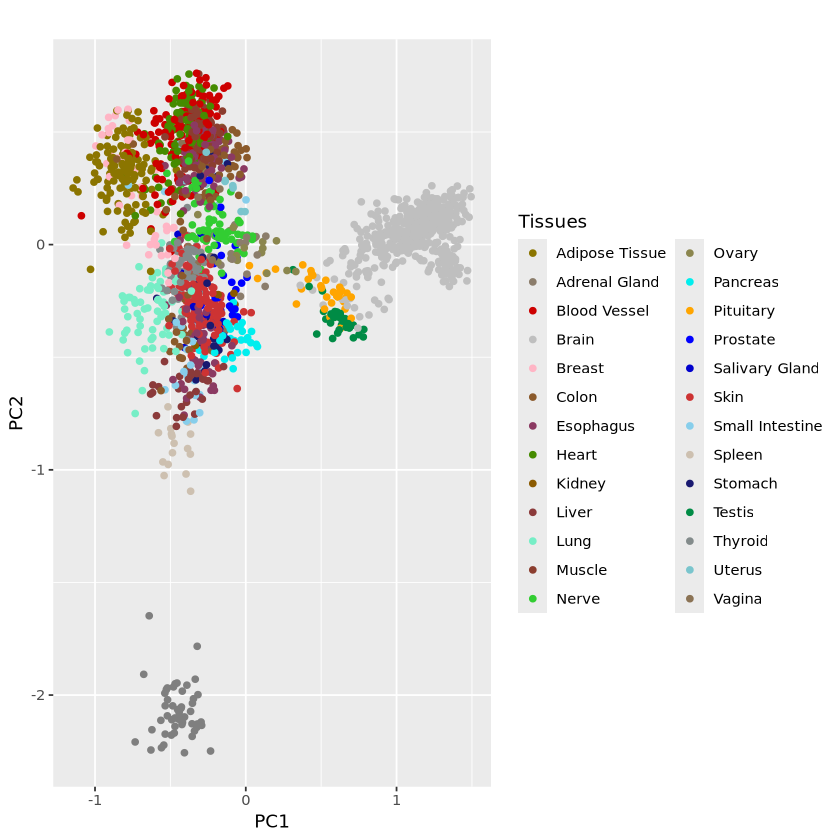

In [9]:
ggplot(data = dtp) + 
  geom_point(aes(x = PC1, y = PC2, col = Tissues)) + scale_color_manual(values = c(  
 "Adipose Tissue" = "gold4",
 "Muscle" = "coral4",
 'Blood Vessel' = "red3",
 "Heart" = "chartreuse4",
 "Uterus" = "cadetblue3",
 "Vagina" = "burlywood4",  
 "Breast" = "pink1",
 "Skin" = "brown3",
 "Salivary Gland" = "blue3", 
 "Brain" = "gray75",
 "Adrenal Gland" = "bisque4",
 "Thyroid" = "azure4",
 "Lung" = "aquamarine2",
 "Spleen" ="antiquewhite3",
 "Pancreas" = "cyan2",
 "Esophagus" = "hotpink4",
 "Stomach" = "midnightblue",
 "Colon" = "tan4",
 "Small Intestine" = "skyblue",
 "Prostate" = "blue",
 "Testis" = "springgreen4",
 "Nerve" = "limegreen",
 "Liver" = "indianred4",
 "Ovary" = "khaki4",
 "Pituitary" = "orange",
 "Whole Blood" = "steelblue4",
 "Kidney" = "orange4")) + ggtitle("")

In [10]:
# calculate circuits higher than q90

In [11]:
tissues <- unique(annot_comp_fcells$tissue)
 
pathvals_var <- as.data.frame(lapply(tissues, function(x) apply(pathvals_fcells_phys[,annot_comp_fcells[which(annot_comp_fcells$tissue == x), "patients"]], 1, var)))
colnames(pathvals_var) <- tissues
rownames(pathvals_var) <- rownames(pathvals_fcells_phys)

pathvals_var_q90 <- data.frame(matrix(0,ncol = length(colnames(pathvals_var)), nrow = length(rownames(pathvals_var))))

rownames(pathvals_var_q90) <- rownames(pathvals_var)
colnames(pathvals_var_q90) <- colnames(pathvals_var)

for (x in 1:length(rownames(pathvals_var_q90))){
    pathvals_var_q90[x,colnames(pathvals_var)[as.numeric(pathvals_var[x,]) > quantile(as.numeric(pathvals_var[x,]), probs=seq(0,1, by=0.05))[19]]] <- 1
}

sum_circ_q90 <- do.call(rbind, lapply(physiological_paths$V1, FUN=function(x)
apply(pathvals_var_q90[grep(x, rownames(pathvals_var_q90)),],2,sum)))
rownames(sum_circ_q90) <- physiological_paths$V1                                       

#ggplot(melt(sum_circ_q90), aes(x = Var2, y = Var1, fill = value)) +
#  geom_tile(color = "gray",
#            lwd = 1,
#            linetype = 1) + scale_fill_continuous(low = "#CCFFFF", high = "#000033") + ggtitle("") + theme(axis.text.x = element_text(angle = 90, hjust = 0))  +
#  xlab("Tissues") + ylab("Signaling Celular Pathway")+ labs(fill = "Sum") 

In [12]:
# get paths q90

In [13]:
physiological_paths <- read.table("/mnt/lustre/scratch/CBRA/projects/heterogeneity/data/physiological_paths.tsv", sep="\t") 
num_circ_paths_fisio <- data.frame("path_fisio"=physiological_paths$V1, "num_circ_fisio"=unlist(lapply(1:length(physiological_paths$V1), FUN=function(x) length(grep(physiological_paths$V1[x], rownames(pathvals_fcells))))))
rownames(num_circ_paths_fisio) <- num_circ_paths_fisio$path_fisio                                                                                                                                                                                                                

In [25]:
perc_circ_q90 <- 
do.call(rbind, lapply(rownames(sum_circ_q90), FUN=function(x) 
(sum_circ_q90[x,] / num_circ_paths_fisio[x,"num_circ_fisio"])*100))

rownames(perc_circ_q90) <- rownames(sum_circ_q90)

perc_circ_q90_p75 <- data.frame(apply(perc_circ_q90 > 75, 2, as.integer))
colnames(perc_circ_q90_p75) <- colnames(perc_circ_q90) 
rownames(perc_circ_q90_p75) <- rownames(perc_circ_q90) 

paths_porc_percq90 <- perc_circ_q90[apply(perc_circ_q90_p75, 1, sum) != 0,apply(perc_circ_q90_p75, 2, sum) != 0]

jpeg("/mnt/lustre/scratch/CBRA/research/projects/heterogeneity_mm/results/03_comparation_between_donors_in_tissue/pathways_more_interdonors_variation.jpeg", quality = 100, width = 700, height = 600)
ggplot(melt(paths_porc_percq90), aes(x = Var2, y = Var1, fill = value)) +
  geom_tile(color = "gray",
            lwd = 1,
            linetype = 1)+ labs(fill="Sum") + scale_fill_continuous(low="#CCCCFF", high="#330D66",na.value="black") + ggtitle("") + 
                      theme(axis.text.y=element_text(size=12) ,axis.text.x = element_text(angle = 90, hjust = 1, size = 13)) +
  xlab("Tissues") + ylab("Signaling Cellular Pathway")
dev.off()                      

png 
  2

In [15]:
### get circs q98

In [16]:
pathvals_var <- as.data.frame(lapply(tissues, function(x) apply(pathvals_fcells_phys[,annot_comp_fcells[which(annot_comp_fcells$tissue == x), "patients"]], 1, var)))
colnames(pathvals_var) <- tissues
rownames(pathvals_var) <- rownames(pathvals_fcells_phys)

pathvals_var_q90 <- data.frame(matrix(0,ncol = length(colnames(pathvals_var)), nrow = length(rownames(pathvals_var))))

rownames(pathvals_var_q90) <- rownames(pathvals_var)
colnames(pathvals_var_q90) <- colnames(pathvals_var)

In [69]:
var_circs_tissue <- as.numeric(unlist(lapply(rownames(pathvals_var), FUN=function(x) 
    quantile(as.numeric(pathvals_var[x,]), probs=seq(0,1, by=0.02))[50])))

In [70]:
pathvals_var_q98 <- do.call(rbind, lapply(1:length(rownames(pathvals_var)), FUN= function(y)
pathvals_var[y,] > var_circs_tissue[y]))

In [71]:
pathvals_var <- as.data.frame(lapply(tissues, function(x) apply(pathvals_fcells_phys[,annot_comp_fcells[which(annot_comp_fcells$tissue == x), "patients"]], 1, var)))
colnames(pathvals_var) <- tissues
rownames(pathvals_var) <- rownames(pathvals_fcells_phys)

pathvals_var_q98 <- data.frame(matrix(0,ncol = length(colnames(pathvals_var)), nrow = length(rownames(pathvals_var))))

rownames(pathvals_var_q98) <- rownames(pathvals_var)
colnames(pathvals_var_q98) <- colnames(pathvals_var)

for (x in 1:length(rownames(pathvals_var_q90))){
    pathvals_var_q98[x,colnames(pathvals_var)[as.numeric(pathvals_var[x,]) > quantile(as.numeric(pathvals_var[x,]), probs=seq(0,1, by=0.02))[50]]] <- 1
}

                                     
#pathvals_var_q98$circs <- rownames(pathvals_var_q98)
#melt(pathvals_var_q98)  %>% 
#ggplot(aes(x= circs, y = variable, fill = value)) +
#  geom_tile()  +
#  scale_x_discrete(name="Tissues",expand = expansion(mult = c(0,0)), guide = guide_axis(angle = 90)) + theme(axis.text.y= element_text(size=8)) + scale_y_discrete(name="Physiological circuits") + ggtitle("") + labs(fill="Sign dif")                                                                             

In [83]:
v_var <- apply(pathvals_fcells_phys, 1, var)
df_var <- data.frame(v_var)

circs_varq95 <- rownames(df_var)[df_var$v_var > quantile(df_var$v_var, probs=seq(0,1, by=0.01))[96]]

In [84]:
pathvals_var_q98$circs <- rownames(pathvals_var_q98)

tisses_circs_var98 <- data.frame("tissues" = colnames(pathvals_var_q98), "circ_q98" =
unlist(lapply(colnames(pathvals_var_q98), FUN=function(x)
paste(melt(pathvals_var_q98[circs_varq95,]) %>% filter(value == 1 & variable == x) %>% select(circs)))))

Using circs as id variables

Using circs as id variables

Using circs as id variables

Using circs as id variables

Using circs as id variables

Using circs as id variables

Using circs as id variables

Using circs as id variables

Using circs as id variables

Using circs as id variables

Using circs as id variables

Using circs as id variables

Using circs as id variables

Using circs as id variables

Using circs as id variables

Using circs as id variables

Using circs as id variables

Using circs as id variables

Using circs as id variables

Using circs as id variables

Using circs as id variables

Using circs as id variables

Using circs as id variables

Using circs as id variables

Using circs as id variables

Using circs as id variables

Using circs as id variables

Using circs as id variables



In [109]:
length(circs_varq95)
length(pathvals_var_q98$circs)

[1] 55

[1] 1098

In [115]:
data.frame(table(unlist(lapply(strsplit(circs_varq95,":", fixed=T), FUN=function(x) x[1])))) %>% filter(Freq > 1)

Var1,Freq
<fct>,<int>
Adherens junction,2
Adipocytokine signaling pathway,2
AMPK signaling pathway,2
Axon guidance,2
Complement and coagulation cascades,2
Focal adhesion,3
Glutamatergic synapse,7
Inflammatory mediator regulation of TRP channels,2
Leukocyte transendothelial migration,3
